# Pretrain Policy with  `MPC dataset`

In [2]:
import numpy as np
import pickle
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from mujoco_parser import MuJoCoParserClass
import torch.optim as optim

from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from util import r2quat

from policy import GaussianPolicy

### Load  `MPC dataset`

In [3]:
with open(file='../data/MPC dataset 0309.pkl', mode='rb') as f:
    dataset = pickle.load(f)

horizon = 50
action = torch.Tensor(dataset['action'])
root_pos = torch.Tensor(dataset['root_pos'])
root_rot = torch.Tensor(dataset['root_rot'])
root_vel = torch.Tensor(dataset['root_vel'])
root_ang_vel = torch.Tensor(dataset['root_ang_vel'])
dof_pos = torch.Tensor(dataset['dof_pos'])
dof_vel = torch.Tensor(dataset['dof_vel'])
local_key_pos = torch.Tensor(dataset['local_key_pos'])

del dataset

# qpos_batch = qpos_batch[:, :]
# qpos_batch = torch.cat((qpos_batch[:-2, :],qpos_batch[1:-1, :],qpos_batch[2:, :]),dim=1)
# qvel_batch = torch.cat((qvel_batch[:-2, :],qvel_batch[1:-1, :],qvel_batch[2:, :]),dim=1)

obs = torch.cat((root_pos[:,2].reshape(-1, 1), root_rot, root_vel, root_ang_vel, dof_pos, dof_vel, local_key_pos.reshape(-1, 12)), dim=1)
next_obs = obs.clone()[1:, :]
obs = obs[:-1,:]
# obs = torch.cat((root_pos, root_rot, root_vel, root_ang_vel, dof_pos, dof_vel), dim=1)

input = torch.cat((obs, action[:-1, :]), dim=1)
output = next_obs

# action_batch = action_batch[2:]
input_dim = obs.shape[1] + action.shape[1]
output_dim = next_obs.shape[1]
hidden_dim = 512

print("input_dim : ", input_dim)
print("output_dim : ", output_dim)


input_dim :  134
output_dim :  97


In [24]:
xml_path = '../asset/smpl_rig/scene_smpl_rig.xml'
env = MuJoCoParserClass(name='smplrig',rel_xml_path=xml_path,VERBOSE=True)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]
print ("Done.")

dt:[0.0083] HZ:[120]
n_dof (=nv):[43]
n_geom:[67]
geom_names:['floor', 'base', 'base2lpelvis', 'base2rpelvis', 'base2spine1', 'spine2spine', 'spine2spine2', 'spine2spine3', 'spine2lcollar', 'spine2rcollar', 'neck2head', 'head', 'nose', 'lcollar2lshoulder', 'lshoulder2lelbow', 'lelbow2lwrist', 'lwrist2lindex1', 'lwrist2lmiddle1', 'lwrist2lpinky1', 'lwrist2lring1', 'lwrist2lthumb1', 'lindex1-lindex2', 'lindex2-lindex3', 'lindex3-lindextip', 'lmiddle1-lmiddle2', 'lmiddle2-lmiddle3', 'lmiddl3-lmiddletip', 'lring1-lring2', 'lring2-lring3', 'lring3-lringtip', 'lpinky1-lpinky2', 'lpinky2-lpinky3', 'lpinky3-lpinkytip', 'lthumb1-lthumb2', 'lthumb2-lthumb3', 'lthumb3-lthumbtip', 'rcollar2rshoulder', 'rshoulder2relbow', 'relbow2rwrist', 'rwrist2rindex1', 'rwrist2rmiddle1', 'rwrist2rpinky1', 'rwrist2rring1', 'rwrist2rthumb1', 'rindex1-rindex2', 'rindex2-rindex3', 'rindex3-rindextip', 'rmiddle1-rmiddle2', 'rmiddle2-rmiddle3', 'rmiddle3-rmiddletip', 'rring1-rring2', 'rring2-rring3', 'rring3-rringtip

In [25]:
world_model = GaussianPolicy(
    input_dim=input_dim,
    output_dim=output_dim,
    hidden_dim=hidden_dim,
    is_deterministic=False,
)

RunningMeanStd:  134
RunningMeanStd:  97


In [26]:
class MPCDataset(Dataset):
    def __init__(self, input, output):
        self.input = input
        # self.obs = (self.obs - self.obs.mean(dim=0)) / self.obs.std(dim=0)
        self.output = output
        # self.act = (self.act - self.act.mean(dim=0)) / self.act.std(dim=0)
        assert self.input.shape[0] == self.output.shape[0]

    def __len__(self):
        return self.input.shape[0]

    def __getitem__(self,idx):
        return self.input[idx], self.output[idx]

In [27]:
train_dataset = MPCDataset(input, output)
train_dataloader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [28]:
world_model.last_fc_log_std.weight

Parameter containing:
tensor([[ 0.5161, -0.9996, -0.7727,  ...,  0.5958,  0.1750, -0.9799],
        [-0.2435,  0.0776,  0.5004,  ..., -0.5184, -0.0820, -0.2314],
        [ 0.1416,  0.6927,  0.0958,  ...,  0.8447,  0.6244,  0.0383],
        ...,
        [ 0.4707, -0.2980,  0.5942,  ..., -0.1630, -0.8477, -0.7216],
        [ 0.3466,  0.7774,  0.3829,  ..., -0.2485, -0.7416,  0.5563],
        [-0.3409,  0.5428, -0.6964,  ..., -0.9199, -0.3982,  0.2140]],
       requires_grad=True)

In [11]:
num_epoch = 1000
optimizer = optim.Adam(world_model.parameters(), lr=1e-5, eps=1e-10, betas=(0.9, 0.95))
loss = torch.nn.MSELoss()
def criterion(output: torch.tensor, y: torch.tensor, mean, std, log_prob):
    diff = output - y

    normal = Normal(mean, std)
    GT_neglogp = -normal.log_prob(y)

    logp_error = torch.mean(GT_neglogp)
    logp_coeff = 1e-2
    pred_error = (torch.mean(torch.abs(diff)))

    return pred_error + logp_error * logp_coeff
    # return torch.mean(torch.sqrt(torch.mean(torch.square(diff),dim=1)))
    # return loss(output, y)

world_model.train()
world_model.running_mean_std.train()
# policy.action_mean_std.train()
for epoch in range(num_epoch):

    with tqdm(train_dataloader, unit="batch") as tepoch:
        
        for x, y in tepoch:
            
            tepoch.set_description(f"Epoch {epoch+1}")

            optimizer.zero_grad()
                
            pred, mean, std, log_prob = world_model(x) # supervised
            l = criterion(pred, y, mean, std, log_prob)
            l.backward()
            optimizer.step()
            
            tepoch.set_postfix(loss=l.item())


Epoch 1000: 100%|██████████| 8/8 [00:00<00:00, 27.25batch/s, loss=0.658]


### Test pretrain model

In [40]:
PLOT = True
world_model.eval()
world_model.running_mean_std.eval()
world_model.is_deterministic = True

In [41]:
LOAD = False
if LOAD:
    file_path = "240313_world_model.pth"
    world_model.load_state_dict((torch.load(file_path)))

In [42]:
# Set which joints to control
ctrl_joint_names = env.ctrl_joint_names # <==
joint_idxs_fwd = env.get_idxs_fwd(joint_names=ctrl_joint_names)
joint_idxs_jac = env.get_idxs_jac(joint_names=ctrl_joint_names)
q_ctrl_init = env.get_qpos_joints(ctrl_joint_names)
n_ctrl_joint = len(ctrl_joint_names)

In [43]:
KEY_BODY_NAMES = ["right_ankle", "left_ankle", "right_wrist", "left_wrist"]
key_body_ids= np.array(env.get_idxs_body(KEY_BODY_NAMES))

/var/folders/xg/3z5dsdd15r74bw6d3yb9_0zw0000gp/T/ipykernel_5636/2375537046.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Pressed ESC
Quitting.


Exception: GLFW window does not exist but you tried to render.

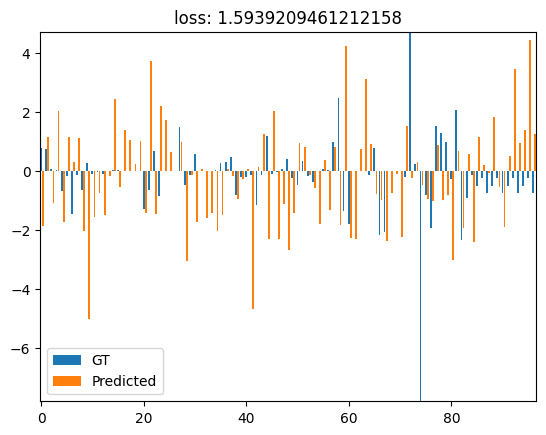

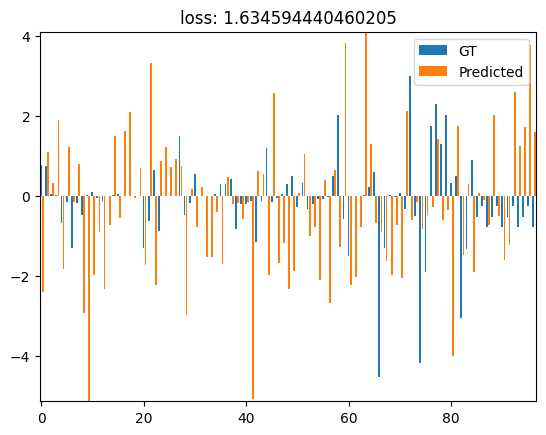

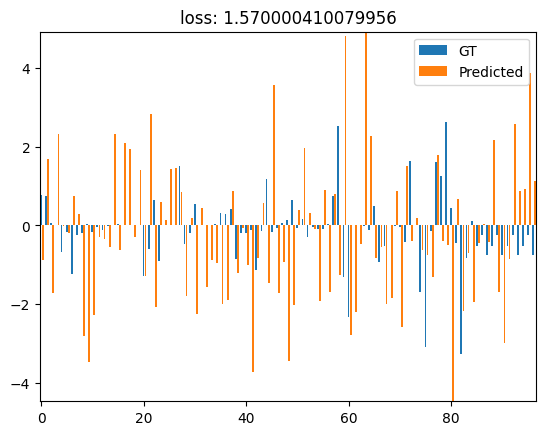

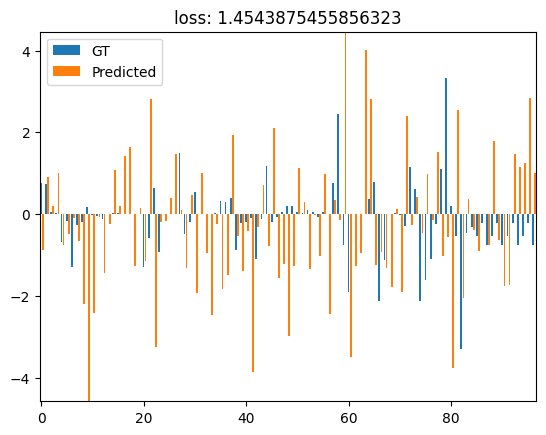

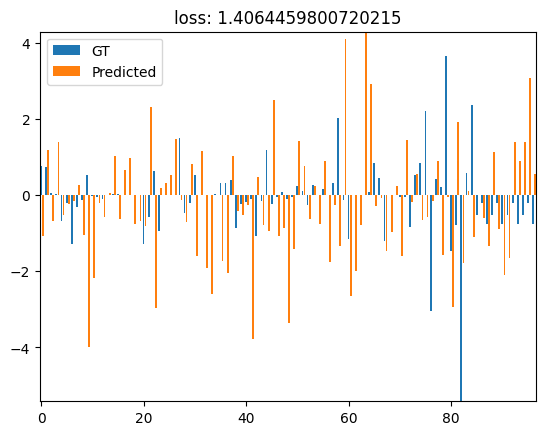

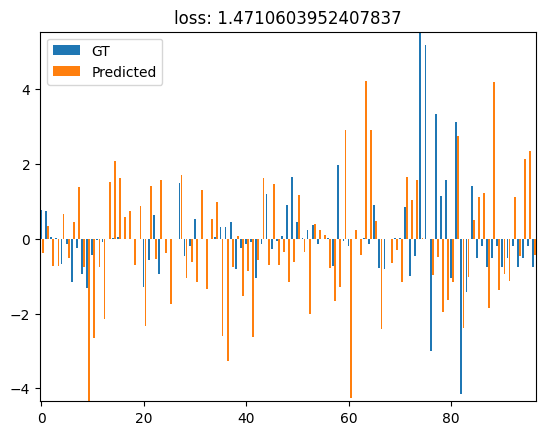

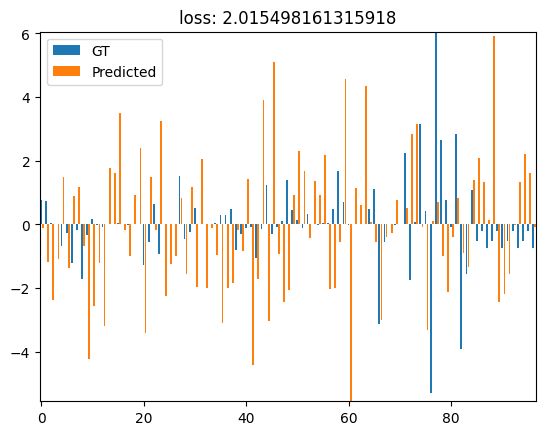

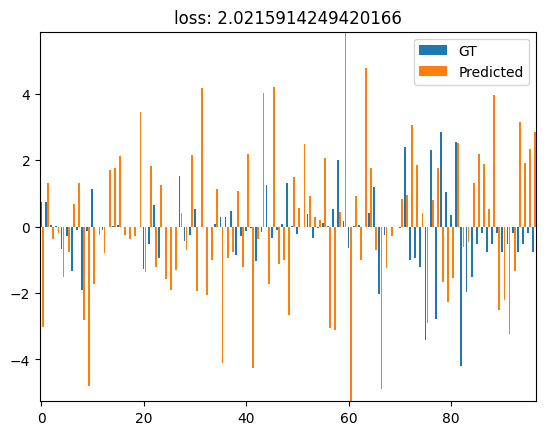

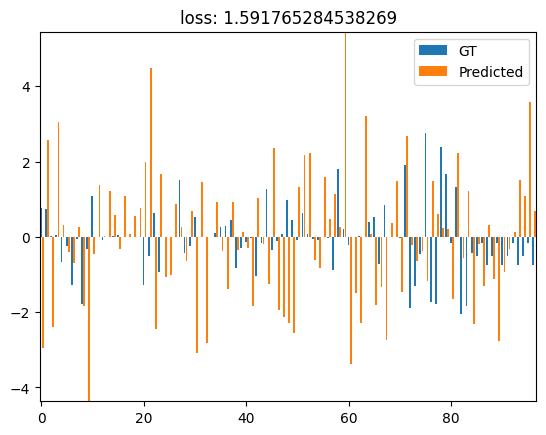

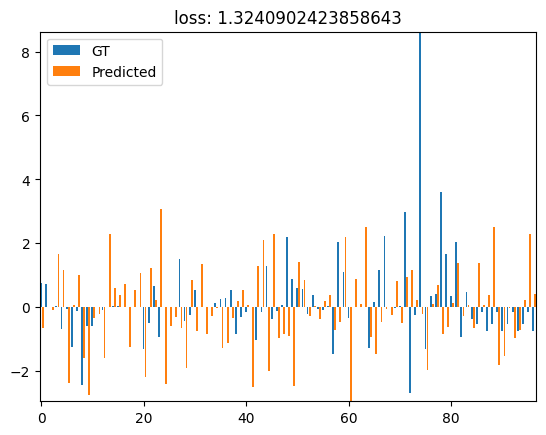

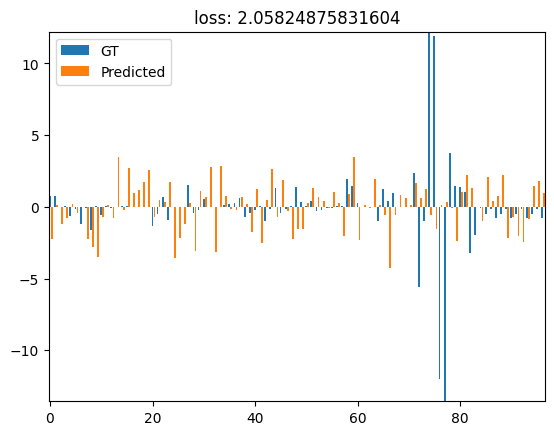

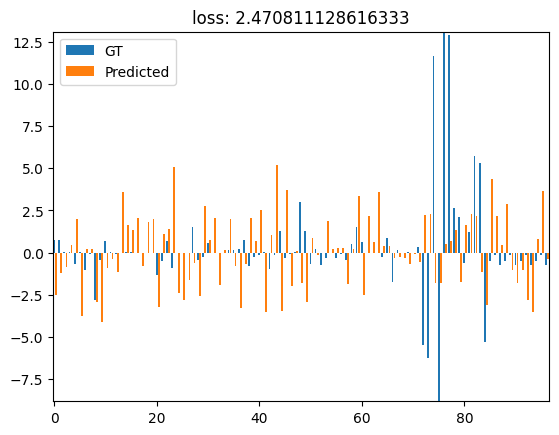

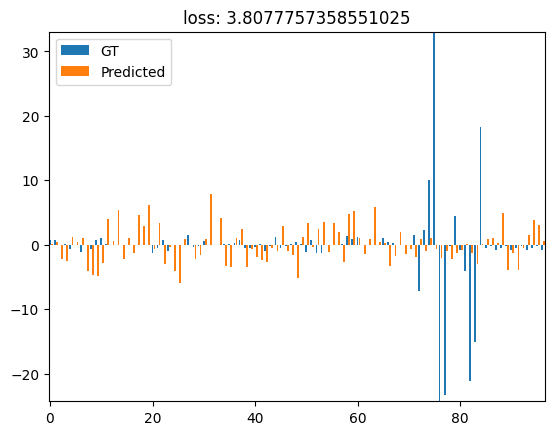

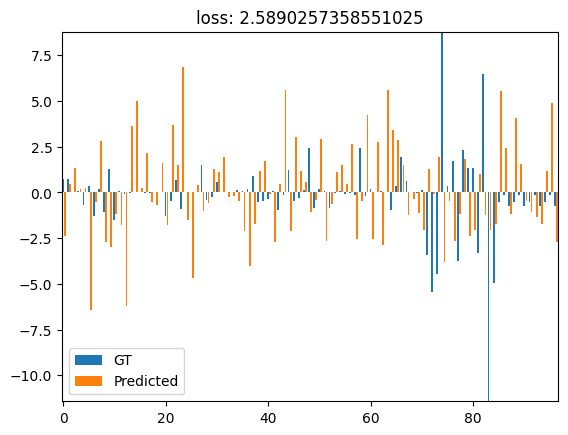

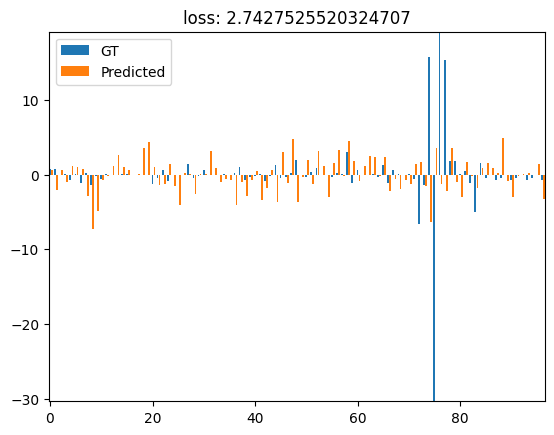

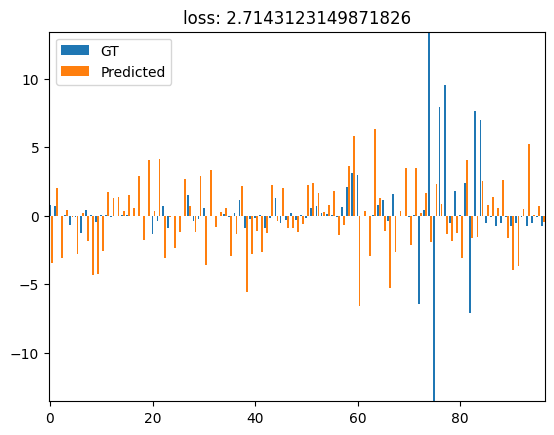

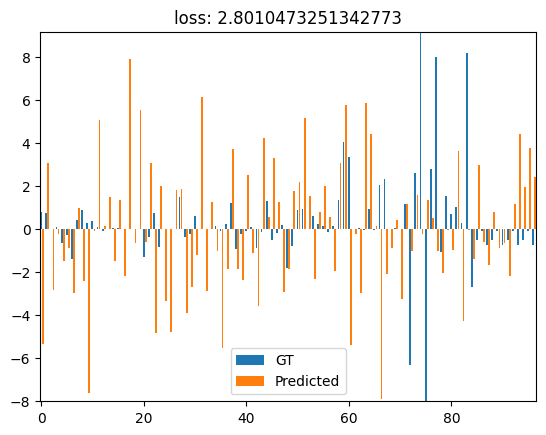

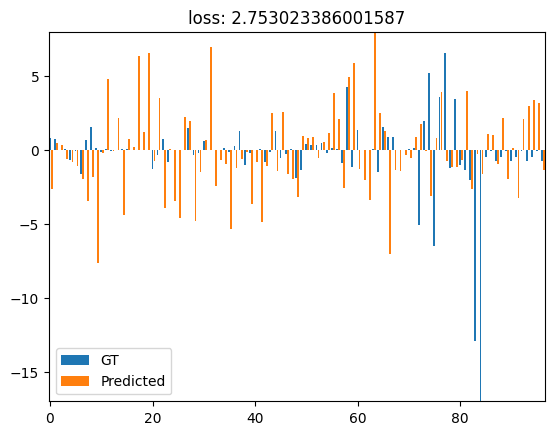

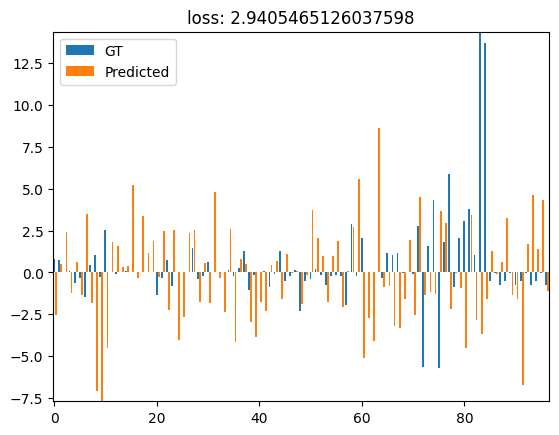

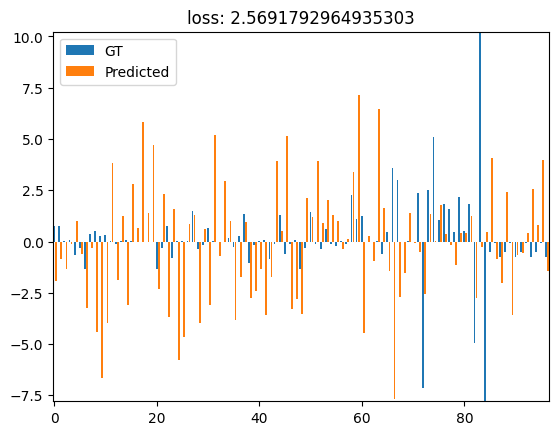

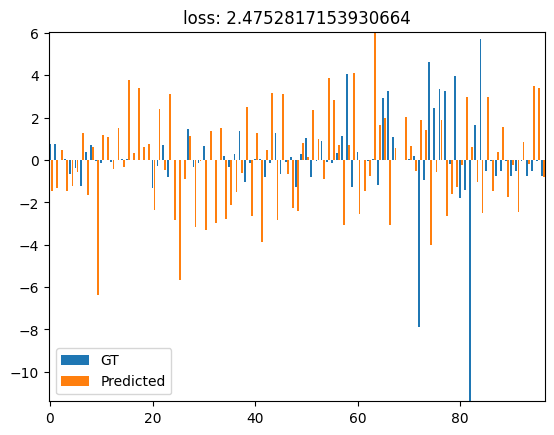

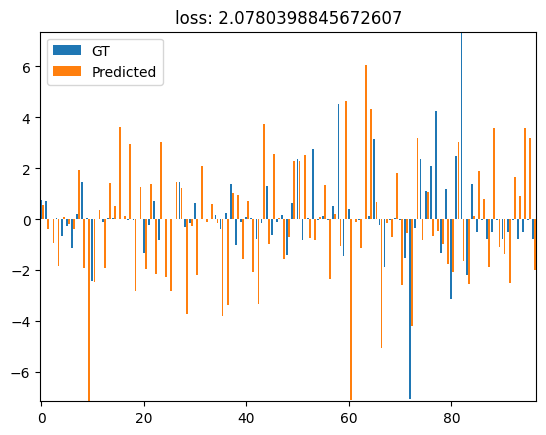

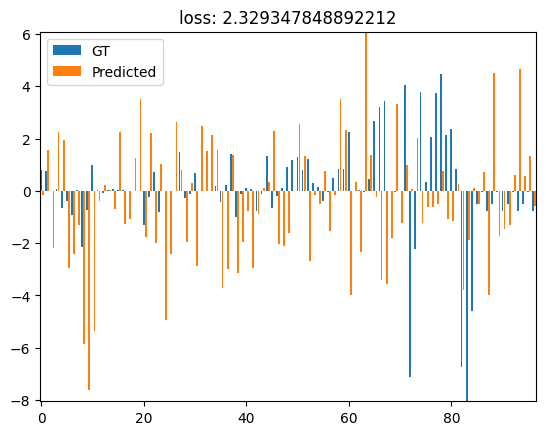

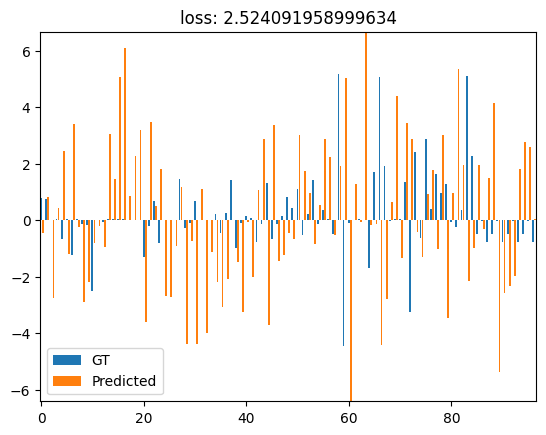

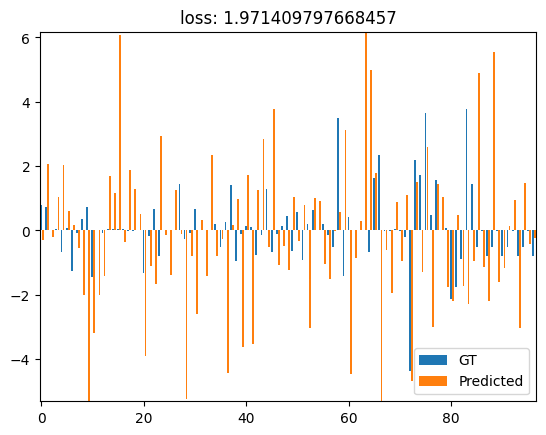

In [44]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='SMPL',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=False)
env.update_viewer(azimuth=152,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

image_list = []

for t in np.arange(130,315):
    rp = root_pos[50*t]
    rr = root_rot[50*t]
    rv = root_vel[50*t]
    rw = root_ang_vel[50*t]
    qpos = dof_pos[50*t]
    qvel = dof_vel[50*t]
    env.data.qvel = torch.cat((rv, rw, qvel))
    env.forward(torch.cat((rp, rr, qpos)))
    for h in range(horizon):
        ctrl = action[50*t+h]
        curr_obs = obs[50*t+h]
        GT_next_obs = next_obs[50*t+h]
        # qpos = env.data.qpos
        # qvel = env.data.qvel
        # root_p, root_R = qpos[:3], qpos[3:7]
        # root_v, root_w = qvel[:3], qvel[3:6]
        # qpos_ = qpos[7:]
        # qvel_ = qvel[6:]
        # key_pos = env.data.xpos[key_body_ids]
        # o = torch.tensor(np.concatenate((root_p[2:], root_R, root_v, root_w, qpos_, qvel_, key_pos.flatten())))
        # a = action[50*t+h]
        curr_input = torch.cat((curr_obs, ctrl))
        pred_next_obs, _, _, _ = world_model(curr_input)
        
        env.step(ctrl.detach().numpy())
        if env.loop_every(tick_every=1):
            # Plot world frame
            env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                    PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
            env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3,3),
                    PLOT_AXIS=False,label="tick:[%d]"%(env.tick))

            # # Stand
            # for p_GT in GT['xpos'][int(t+h)]:
            #     env.plot_sphere(p=p_GT,r=0.02,rgba=[1,0.2,0.2,1])
            
            env.render()

            # if SAVE_VID:
            #     # Save iamges
            #     png_path = '../temp/smplrig_MPC_%05d.png'%(env.tick)
            #     create_folder_if_not_exists(png_path)
            #     image = cv2.cvtColor(env.grab_image(),cv2.COLOR_RGB2BGR)
            #     cv2.imwrite(png_path,image)
            if PLOT:
                fig, ax = plt.subplots()
                ax.bar(np.arange(output_dim)-0.2, GT_next_obs, width = 0.35, align='edge', label='GT')
                ax.bar(np.arange(output_dim)+0.2, pred_next_obs.detach(), width = 0.35, align='edge', label='Predicted')
                ax.set_title("loss: {}".format(
                    torch.mean(torch.abs(GT_next_obs-pred_next_obs.detach()))
                ))
                ax.legend()
                ax.margins(0)
                fig.canvas.draw()

                image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
                image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))

                image_list.append(image_from_plot)


In [35]:
file_name = "240313_world_model.pth"
torch.save(world_model.state_dict(), file_name)

In [36]:
world_model.state_dict()

OrderedDict([('fc_layers.0.weight',
              tensor([[ 0.0749, -0.0045, -0.0587,  ...,  0.0233, -0.0429, -0.0609],
                      [ 0.0721, -0.0619, -0.0564,  ...,  0.0046, -0.0562, -0.0405],
                      [ 0.0702, -0.0039, -0.0638,  ...,  0.0294,  0.0247, -0.0615],
                      ...,
                      [ 0.0380,  0.0206, -0.0625,  ..., -0.0537,  0.0371,  0.0525],
                      [-0.0066, -0.0427, -0.0477,  ...,  0.0542,  0.0535,  0.0112],
                      [ 0.0763, -0.0163,  0.0162,  ..., -0.0816, -0.0023,  0.0706]])),
             ('fc_layers.0.bias',
              tensor([ 3.7829e-02, -2.0224e-02,  6.7540e-02,  6.9285e-02,  2.7043e-02,
                      -2.8229e-02, -5.4714e-02, -4.9638e-02, -5.3067e-02,  2.5562e-02,
                      -5.1182e-03, -6.6975e-02,  4.2917e-02, -2.8702e-02,  8.5047e-04,
                      -7.4979e-02,  1.7967e-02, -7.7517e-03,  1.2336e-02, -1.0497e-02,
                      -7.4586e-02,  4.5132e-02, 